In [ ]:
# 1. INSTALL DEPENDENCIES & IMPORT LIBRARIES
print(" Installing and Importing Libraries ")
!pip install transformers -q
!pip install tensorflow -q
!pip install scikit-learn -q
!pip install pandas -q
!pip install matplotlib -q
!pip install gradio -q

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Layer
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score, f1_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from google.colab import files, drive
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import re
from pathlib import Path
import shutil
import json
import io
import sys
import transformers as hf_transformers
import sklearn
import gradio as gr

# DATA LOADING AND PREPROCESSING
print("\n Loading and Preprocessing Data")

def clean_text(text: str) -> str:
    """Cleans the input text."""
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

if 'google.colab' in sys.modules:
    if not os.path.exists('archive.zip'):
        uploaded = files.upload()

with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

fake_df = pd.read_csv('/content/data/Fake.csv')
true_df = pd.read_csv('/content/data/True.csv')

# ADDRESSING DATA LEAKAGE
true_df['text'] = true_df['text'].apply(lambda x: x.split(' - ', 1)[-1])

fake_df['label'] = 1
true_df['label'] = 0

df = pd.concat([fake_df, true_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['content'] = (df['title'].astype(str) + ' ' + df['text'].astype(str)).apply(clean_text)
df = df[['content', 'label']]

print(f"\nDataset loaded successfully with {len(df)} articles.")
print("Class distribution:\n", df['label'].value_counts())

--- Section 0: Installing and Importing Libraries ---

 Loading and Preprocessing Data


Saving archive.zip to archive.zip

Dataset loaded successfully with 44898 articles.
Class distribution:
 label
1    23481
0    21417
Name: count, dtype: int64


In [ ]:
# 2: DEFINING THE BERT-CNN MODEL (With Regularization)
print("\n Defining Tokenizer and BERT-CNN Model")

# Model Parameters
MAX_LEN = 128
MODEL_NAME = 'bert-base-uncased'

bert_tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_data(X, tokenizer, max_len):
    """Tokenizes a list of texts."""
    return tokenizer(
        text=list(X), add_special_tokens=True, max_length=max_len,
        truncation=True, padding='max_length', return_tensors='tf',
        return_attention_mask=True, verbose=False
    )

class BertFeatureExtractor(Layer):
    """Custom Keras layer for BERT feature extraction."""
    def __init__(self, model_name='bert-base-uncased', **kwargs):
        super(BertFeatureExtractor, self).__init__(**kwargs)
        self.model_name = model_name
        self.bert = TFBertModel.from_pretrained(self.model_name, from_pt=True)
        self.bert.trainable = False

    def call(self, inputs):
        return self.bert(inputs).last_hidden_state

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": self.model_name})
        return config

def create_bert_cnn_model(max_len=MAX_LEN, bert_model_name=MODEL_NAME):
    """Creates the combined BERT and CNN model."""
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    bert_extractor = BertFeatureExtractor(model_name=bert_model_name)
    bert_output = bert_extractor({'input_ids': input_ids, 'attention_mask': attention_mask})

    cnn_layer = Conv1D(filters=64, kernel_size=3, padding="valid", activation="relu")(bert_output)
    pooling_layer = GlobalMaxPooling1D()(cnn_layer)
    x = Dropout(0.6)(pooling_layer)
    x = Dense(32, activation="tanh")(x)
    x = Dropout(0.6)(x)
    output = Dense(1, activation="sigmoid", name="classification")(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Display the summary
model_for_summary = create_bert_cnn_model()
print("\nBERT-CNN Model Architecture:")
model_for_summary.summary()
del model_for_summary # Clean up



 Defining Tokenizer and BERT-CNN Model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Al


BERT-CNN Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_feature_extra… │ (None, 128, 768)  │          0 │ attention_mask[0… │
│ (BertFeatureExtrac… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 64)   │    147,520 │ bert_feature_ext… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         33 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 149,633 (584.50 KB)

 Trainable params: 149,633 (584.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3. K-FOLD CROSS-VALIDATION
print("\n K-Fold Cross-Validation")

# First, split off a final held-out test set (10% of the data)
X = df['content']
y = df['label']
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# K-Fold Parameters
N_SPLITS = 5  # Number of folds
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Store scores from each fold
cv_val_accuracies = []
cv_val_losses = []

# K-Fold Loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
    print(f"\n===== FOLD {fold + 1}/{N_SPLITS} =====")

    # 1. Get data for the current fold
    X_train_fold = X_train_val.iloc[train_idx]
    y_train_fold = y_train_val.iloc[train_idx]
    X_val_fold = X_train_val.iloc[val_idx]
    y_val_fold = y_train_val.iloc[val_idx]

    # 2. Tokenize the fold data
    X_train_token = tokenize_data(X_train_fold, bert_tokenizer, MAX_LEN)
    X_val_token = tokenize_data(X_val_fold, bert_tokenizer, MAX_LEN)

    # 3. Create trained model for each fold
    model = create_bert_cnn_model()

    # 4. Compile the model
    optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # 5. Define Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=1, min_lr=1e-7)

    # 6. Train the model
    history = model.fit(
        x={'input_ids': X_train_token['input_ids'], 'attention_mask': X_train_token['attention_mask']},
        y=y_train_fold,
        validation_data=(
            {'input_ids': X_val_token['input_ids'], 'attention_mask': X_val_token['attention_mask']},
            y_val_fold
        ),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # 7. Store the best validation score for this fold
    best_val_loss_idx = np.argmin(history.history['val_loss'])
    best_val_accuracy = history.history['val_accuracy'][best_val_loss_idx]
    best_val_loss = history.history['val_loss'][best_val_loss_idx]

    cv_val_accuracies.append(best_val_accuracy)
    cv_val_losses.append(best_val_loss)
    print(f"Fold {fold + 1} Best Validation Accuracy: {best_val_accuracy:.4f}")
    print(f"Fold {fold + 1} Best Validation Loss: {best_val_loss:.4f}")


# Report Cross-Validation Results
print("\n--- Cross-Validation Summary ---")
print(f"Average Validation Accuracy: {np.mean(cv_val_accuracies):.4f} +/- {np.std(cv_val_accuracies):.4f}")
print(f"Average Validation Loss:     {np.mean(cv_val_losses):.4f} +/- {np.std(cv_val_losses):.4f}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



 K-Fold Cross-Validation

===== FOLD 1/5 =====


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Epoch 1/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 352s 327ms/step - accuracy: 0.5339 - loss: 0.9240 - val_accuracy: 0.9230 - val_loss: 0.3368 - learning_rate: 2.0000e-05
Epoch 2/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 321s 318ms/step - accuracy: 0.6815 - loss: 0.6229 - val_accuracy: 0.9396 - val_loss: 0.2044 - learning_rate: 2.0000e-05
Epoch 3/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.8283 - loss: 0.3905 - val_accuracy: 0.9465 - val_loss: 0.1655 - learning_rate: 2.0000e-05
Epoch 4/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.8911 - loss: 0.2892 - val_accuracy: 0.9555 - val_loss: 0.1353 - learning_rate: 2.0000e-05
Epoch 5/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.9201 - loss: 0.2333 - val_accuracy: 0.9623 - val_loss: 0.1148 - learning_rate: 2.0000e-05
Epoch 6/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 301s 297ms/step - accuracy: 0.9347 - loss: 0.1988 - val_accuracy: 0.9665 - val_loss: 0.0981 - learning_rate: 2.0000e-05
Epoch 7/10
1011/1011 ━━━━━━━

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Epoch 1/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 334s 312ms/step - accuracy: 0.5173 - loss: 0.8973 - val_accuracy: 0.8983 - val_loss: 0.3875 - learning_rate: 2.0000e-05
Epoch 2/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 321s 318ms/step - accuracy: 0.6789 - loss: 0.6065 - val_accuracy: 0.9318 - val_loss: 0.2243 - learning_rate: 2.0000e-05
Epoch 3/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.8478 - loss: 0.3635 - val_accuracy: 0.9478 - val_loss: 0.1651 - learning_rate: 2.0000e-05
Epoch 4/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.9110 - loss: 0.2641 - val_accuracy: 0.9564 - val_loss: 0.1291 - learning_rate: 2.0000e-05
Epoch 5/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.9294 - loss: 0.2175 - val_accuracy: 0.9639 - val_loss: 0.1071 - learning_rate: 2.0000e-05
Epoch 6/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.9419 - loss: 0.1792 - val_accuracy: 0.9673 - val_loss: 0.0916 - learning_rate: 2.0000e-05
Epoch 7/10
1011/1011 ━━━━━━━

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Epoch 1/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 334s 313ms/step - accuracy: 0.5339 - loss: 0.9571 - val_accuracy: 0.8979 - val_loss: 0.3958 - learning_rate: 2.0000e-05
Epoch 2/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 381s 318ms/step - accuracy: 0.6626 - loss: 0.6765 - val_accuracy: 0.9409 - val_loss: 0.1976 - learning_rate: 2.0000e-05
Epoch 3/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 300s 296ms/step - accuracy: 0.8368 - loss: 0.3711 - val_accuracy: 0.9525 - val_loss: 0.1534 - learning_rate: 2.0000e-05
Epoch 4/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 343s 318ms/step - accuracy: 0.8983 - loss: 0.2679 - val_accuracy: 0.9579 - val_loss: 0.1271 - learning_rate: 2.0000e-05
Epoch 5/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 317ms/step - accuracy: 0.9243 - loss: 0.2186 - val_accuracy: 0.9633 - val_loss: 0.1080 - learning_rate: 2.0000e-05
Epoch 6/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 321s 318ms/step - accuracy: 0.9378 - loss: 0.1825 - val_accuracy: 0.9688 - val_loss: 0.0949 - learning_rate: 2.0000e-05
Epoch 7/10
1011/1011 ━━━━━━━

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Epoch 1/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 350s 329ms/step - accuracy: 0.5451 - loss: 0.8985 - val_accuracy: 0.9280 - val_loss: 0.2907 - learning_rate: 2.0000e-05
Epoch 2/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 365s 318ms/step - accuracy: 0.7294 - loss: 0.5497 - val_accuracy: 0.9469 - val_loss: 0.1748 - learning_rate: 2.0000e-05
Epoch 3/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.8659 - loss: 0.3304 - val_accuracy: 0.9562 - val_loss: 0.1417 - learning_rate: 2.0000e-05
Epoch 4/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.9126 - loss: 0.2473 - val_accuracy: 0.9629 - val_loss: 0.1174 - learning_rate: 2.0000e-05
Epoch 5/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 300s 297ms/step - accuracy: 0.9321 - loss: 0.2070 - val_accuracy: 0.9675 - val_loss: 0.1015 - learning_rate: 2.0000e-05
Epoch 6/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 344s 318ms/step - accuracy: 0.9418 - loss: 0.1850 - val_accuracy: 0.9709 - val_loss: 0.0875 - learning_rate: 2.0000e-05
Epoch 7/10
1011/1011 ━━━━━━━

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Epoch 1/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 335s 313ms/step - accuracy: 0.5336 - loss: 0.8870 - val_accuracy: 0.8818 - val_loss: 0.4400 - learning_rate: 2.0000e-05
Epoch 2/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 380s 318ms/step - accuracy: 0.6489 - loss: 0.6673 - val_accuracy: 0.9364 - val_loss: 0.2332 - learning_rate: 2.0000e-05
Epoch 3/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.8268 - loss: 0.3957 - val_accuracy: 0.9505 - val_loss: 0.1698 - learning_rate: 2.0000e-05
Epoch 4/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.8950 - loss: 0.2872 - val_accuracy: 0.9582 - val_loss: 0.1339 - learning_rate: 2.0000e-05
Epoch 5/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.9202 - loss: 0.2329 - val_accuracy: 0.9630 - val_loss: 0.1109 - learning_rate: 2.0000e-05
Epoch 6/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 322s 318ms/step - accuracy: 0.9393 - loss: 0.1929 - val_accuracy: 0.9666 - val_loss: 0.0955 - learning_rate: 2.0000e-05
Epoch 7/10
1011/1011 ━━━━━━━

In [ ]:
# 4. FINAL MODEL TRAINING
print("\n Training Final Model on Full Training Data")

# Train the definitive model on the entire training+validation set
print("Tokenizing all training data...")
X_train_val_token = tokenize_data(X_train_val, bert_tokenizer, MAX_LEN)
X_test_token = tokenize_data(X_test, bert_tokenizer, MAX_LEN) # Also tokenize test set for final eval

# Create and compile the final model
final_model = create_bert_cnn_model()
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)
final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

print("\nStarting final model training...")
# No validation data here as we use all data for training.
# We also train for a fixed number of epochs based on insights from CV.
history = final_model.fit(
    x={'input_ids': X_train_val_token['input_ids'], 'attention_mask': X_train_val_token['attention_mask']},
    y=y_train_val,
    epochs=3,
    batch_size=32,
    verbose=1
)


 Training Final Model on Full Training Data
Tokenizing all training data...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already


Starting final model training...
Epoch 1/3
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 326s 243ms/step - accuracy: 0.5394 - loss: 0.8741
Epoch 2/3
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 307s 237ms/step - accuracy: 0.7654 - loss: 0.4862
Epoch 3/3
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 322s 237ms/step - accuracy: 0.8952 - loss: 0.2814



 Evaluating the Final Model on the Test Set
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 282ms/step

 Classification Report on Test Set:
              precision    recall  f1-score   support

    Real (0)       0.97      0.95      0.96      2142
    Fake (1)       0.96      0.97      0.96      2348

    accuracy                           0.96      4490
   macro avg       0.96      0.96      0.96      4490
weighted avg       0.96      0.96      0.96      4490


 Confusion Matrix:


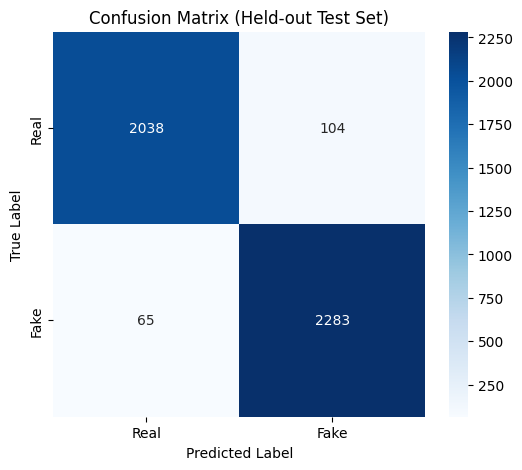

In [ ]:
# 5: EVALUATING THE FINAL MODEL ON THE HELD-OUT TEST SET
print("\n Evaluating the Final Model on the Test Set")

# Make predictions on the unseen test set
predicted_probabilities = final_model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})
binary_predictions = (predicted_probabilities > 0.5).astype(int)

# Generate Classification Report and Confusion Matrix
print("\n Classification Report on Test Set:")
print(classification_report(y_test, binary_predictions, target_names=['Real (0)', 'Fake (1)']))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, binary_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Held-out Test Set)")
plt.show()

In [ ]:
# Section 6: Saving the Final Model and Test Data
import json
from pathlib import Path
import shutil
from google.colab import drive
import pandas as pd

print("\n--- Section 6: Saving Model Artifacts and Test Data ---")

# Mount Google Drive
drive.mount('/content/drive')

# Define an output directory, clearing it first for a clean save
output_dir = Path("/content/drive/MyDrive/fake_news_models_k-folds/Latest_BertCNN")

if output_dir.exists():
    print(f"Removing existing directory: {output_dir}")
    shutil.rmtree(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
print(f"\nArtifacts will be saved to: {output_dir}")

# 1. Save the final trained model (architecture + weights)
# Use model.save() and the modern .keras extension.
model_path = output_dir / "model.keras"
final_model.save(model_path)
print(f"-> Full model saved successfully to: {model_path}")

# 2. Save the tokenizer
tokenizer_path = output_dir / "tokenizer"
bert_tokenizer.save_pretrained(str(tokenizer_path))
print(f"-> Tokenizer saved successfully to: {tokenizer_path}")

# 3. Save the configuration file
config = {"model_name": MODEL_NAME, "max_len": MAX_LEN}
config_path = output_dir / "config.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"-> Model configuration saved successfully to: {config_path}")

# 4. Save the held-out test set for consistent evaluation
print("\nSaving the held-out test dataset...")
test_df = pd.DataFrame({
    'content': X_test,  # The test data from initial split
    'label': y_test
})
test_data_path = output_dir / "test_data.csv"
test_df.to_csv(test_data_path, index=False)
print(f"-> Test data saved successfully to: {test_data_path}")

print("\n All artifacts, including the test set, have been saved.")


--- Section 6: Saving Model Artifacts and Test Data ---
Mounted at /content/drive
Removing existing directory: /content/drive/MyDrive/fake_news_models_k-folds/Latest_BertCNN

Artifacts will be saved to: /content/drive/MyDrive/fake_news_models_k-folds/Latest_BertCNN
-> Full model saved successfully to: /content/drive/MyDrive/fake_news_models_k-folds/Latest_BertCNN/model.keras
-> Tokenizer saved successfully to: /content/drive/MyDrive/fake_news_models_k-folds/Latest_BertCNN/tokenizer
-> Model configuration saved successfully to: /content/drive/MyDrive/fake_news_models_k-folds/Latest_BertCNN/config.json

Saving the held-out test dataset...
-> Test data saved successfully to: /content/drive/MyDrive/fake_news_models_k-folds/Latest_BertCNN/test_data.csv

 All artifacts, including the test set, have been saved.
